# ST590 Project 3
## Jovanni Catalan & Sergio Mora

In [1]:
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pandas as pd
import numpy as np
import pyspark.pandas as ps
import pyspark
from pyspark.sql import SparkSession

In [148]:
import statistics as st
import matplotlib as mt
import matplotlib.pyplot as plt
import sqlite3 
import matplotlib.pyplot as plot
import plotly.graph_objects as go
import plotly.express as px
from pandasql import sqldf
from sklearn import metrics

In [3]:
# Reading in the sqlite data
cnx = sqlite3.connect(':memory:')

### Introduction
You should discuss the goals of the notebook, introduce your data set, and give the source for your data set

The goal of this notebook is to have a clear understanding of obesity rates in Mexico, Peru, and Colombia based on multiple metrics collected. This data comes to us from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+) which gathered this data from [Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico](https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub). 

The data set has 17 columns and 2,111 observations. The columns are:

Gender: Patients gender {object}  
  -  female  
  -  male 

Age: Patients age {float}

Height: Patients height {float}

Weight: Patients weight {float}

family_history_with_overweight: If the patients has a family history of overweight people {object}
  - Yes  
  - No
  
FAVC: Frequent Consumption of High Caloric Food {objects}  
  - Yes
  - No
  
FCVC: Frequent Consumption of Vegetables {float} <font color='red'>This is different from the article need review</font> 
  - 1 through 3 meaning 
    - never  
    - sometimes  
    - always  

NCP: Number of Main Meals (how many meals the patient has daily) {float}  <font color='red'>This is different from the article need review</font> 
  - 1 through 3 meaning 
    - Between 1 and 2  
    - Three   
    - More than three  

CAEC: Consumption of food between meals {object}  
  - No  
  - Sometimes  
  - Frequently  
  - Always  

SMOKE: Does the patient smoke {object}
  - Yes  
  - No  

CH20: Consumption of water in liters {float} <font color='red'>This is different from the article need review</font> 

SCC: Does the patient monitor the calories they consume {object}
  - Yes  
  - No

FAF: How often does the patient have physical activity {float} <font color='red'>This is different from the article need review, There is also some overlap</font> 
  - 0 through 3 meaning 
    - I do not
    - 1 or 2 days
    - 2 or 4 days
    - 4 or 5 days


TUE: How often does the patient utilize technological devices {float} (e.g. phone, video games, TV's, computers, etc.) {float} <font color='red'>This is different from the article need review</font> 
  - 1 through 3 meaning 
    - 0-2 hours
    - 3-5 hours
    - More than 5 hours  

CALC: consumption of alcohol, how often does the patient drink alcohol {object}
  - No (the patient does not drink alcohol)  
  - Sometimes  
  - Frequently  
  - Always  

MTRANS: What type of transportation does the patient normally use {object}
  - Automobile  
  - Motorbike  
  - Bike  
  - Public Transportation  
  - Walking  

NObeyesdad: Patients weight status {object}
  
  - Insufficient Weight  
  - Normal Weight  
  - Obesity Type I  
  - Obesity Type II  
  - Obesity Type III 
  - Overweight Level I
  - Overweight Level II 
  
Obesity levels defined as:   


<img src="WHO BMI.PNG" width=400 height=400 />


In [4]:
Obesity_data = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
Obesity_data.to_sql(name='Obesity_data', con=cnx, index = False)

In [23]:
# Doing an initial data pull to understand the data
sample_data = pd.read_sql("""
 SELECT * 
 FROM Obesity_data limit 5
""",cnx)
sample_data


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Supervised Learning Idea and Data Split

Give a discussion as to why we want to what we are generally trying to do with supervised learning where prediction is our goal. Discuss why we want to split our data into a training and test set.


You should also split the data into a training and test set

### EDA 

You should have a narrative that goes through what you are trying to accomplish in the EDA, why you are looking at a particular graph or statistic, and how you interpret what you’ve made. The EDA should be done on the training data only. You should use pandas-on-spark or spark SQL data frames (but matplotlib is fine)

Part of the final’s purpose is to see if you can judge what should and shouldn’t be included in an EDA.

#### Gender

No real assumption is made here prior to observing the data as we have no reason to believe that either gender would be more likely to face obesity than the other.

In [22]:
# Understanding how our population is split by gender
gender_split = pd.read_sql("""
select NObeyesdad,
gender,
count(*) as counts
from Obesity_data
group by 1,2
""",cnx)
gender_split

,NObeyesdad,Gender,counts
0,Insufficient_Weight,Female,173
1,Insufficient_Weight,Male,99
2,Normal_Weight,Female,141
3,Normal_Weight,Male,146
4,Obesity_Type_I,Female,156
5,Obesity_Type_I,Male,195
6,Obesity_Type_II,Female,2
7,Obesity_Type_II,Male,295
8,Obesity_Type_III,Female,323
9,Obesity_Type_III,Male,1


Although not a huge data set it is still hard to understand our results in this format. The visualization below should help us out.

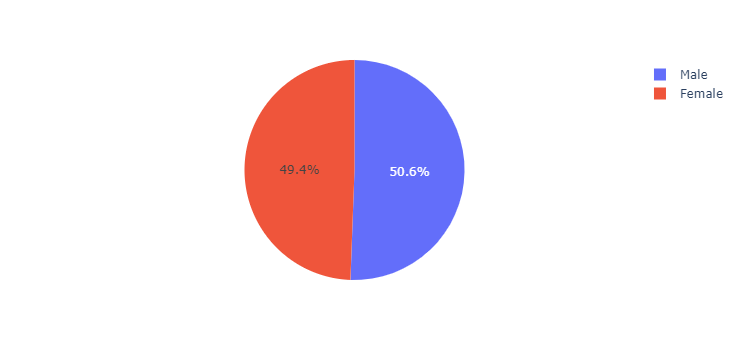

In [14]:
fig = px.pie(gender_split, values='counts', names='Gender')
fig.show()

We see that overall our data is very evenly split when it comes to gender. This shouldn't come as a surprise to us. Further analysis should show if there is a correlation between gender and obesity rate.

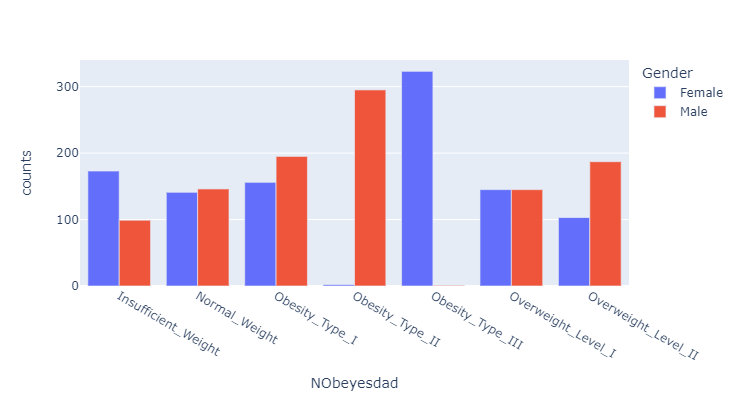

In [20]:
fig = px.bar(gender_split, x="NObeyesdad", y="counts",
             color='Gender',barmode='group',
             height=400)
fig.show()

Immediately we start to see some interesting feature of our data. We see the following:

Insufficient Weight: There are more women in who are of insufficient weight than men. This could have multiple reasons but one that comes to mind is the pressure on young women to thin.

Normal Weight: This is evenly split.

Obesity Type I: This is skewed male but not overly so.

Obesity Type II: Is predominantly male, this could be attributed to the way BMI is measure utilizing only weight and height and not higher than average muscle mass which many young men tend to have.

Obesity Type III: This is surprisingly almost entirely female. Because this is measure based on BMI it might stand to reason that if a man and a woman weigh the same a woman would likely have a higher BMI do to either height differences or assumed muscle mass differences.

Overweight Level I and II: These measurements seems to be fairly evenly split between gender with male being on the heavier side.

#### Smoke

An assumption made here is that smoking would correlate to someone being overweight and obese. The idea that one bad habit could lead to another as well as the assumption that smokers are less healthy *because* they smoke and thus might excessive less. 

In [27]:
# Understanding how our population is split by gender
Smoke_split = pd.read_sql("""
select NObeyesdad,
Smoke,
count(*) as counts
from Obesity_data
group by 1,2
""",cnx)
Smoke_split

,NObeyesdad,SMOKE,counts
0,Insufficient_Weight,no,271
1,Insufficient_Weight,yes,1
2,Normal_Weight,no,274
3,Normal_Weight,yes,13
4,Obesity_Type_I,no,345
5,Obesity_Type_I,yes,6
6,Obesity_Type_II,no,282
7,Obesity_Type_II,yes,15
8,Obesity_Type_III,no,323
9,Obesity_Type_III,yes,1


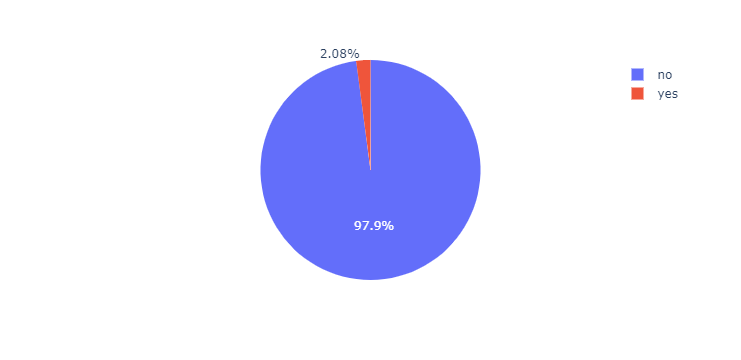

In [28]:
fig = px.pie(Smoke_split, values='counts', names='SMOKE')
fig.show()

We see that the vast majority of our data set shows that people in mass do not smoke. For this reason further analysis on this variable would be hard to visualize without accounting for the near 49:1 ratio.

#### Age

Two opposing thoughts here are that younger people would be more fit due to their age and potentially being more active. However obese people might not make it to an older age to skew the data. 

In [129]:
# Understanding how our population is split by gender
Age_split = pd.read_sql("""
select NObeyesdad,
AVG(age) as mean_age
from Obesity_data
group by 1
""",cnx)
Age_split

,NObeyesdad,mean_age
0,Insufficient_Weight,19.783237
1,Normal_Weight,21.738676
2,Obesity_Type_I,25.884941
3,Obesity_Type_II,28.233785
4,Obesity_Type_III,23.495554
5,Overweight_Level_I,23.417674
6,Overweight_Level_II,26.996981


In [132]:
# Creating a helper function for the graph below.
def lines_on_graph(position,height):
    fig.add_trace(go.Scatter(
    x=[Age_split['mean_age'].iloc[position],Age_split['mean_age'].iloc[position]],
    y=[0,height],
    mode="lines",
    name=Age_split['NObeyesdad'].iloc[position],
    textposition="top center"
    ))

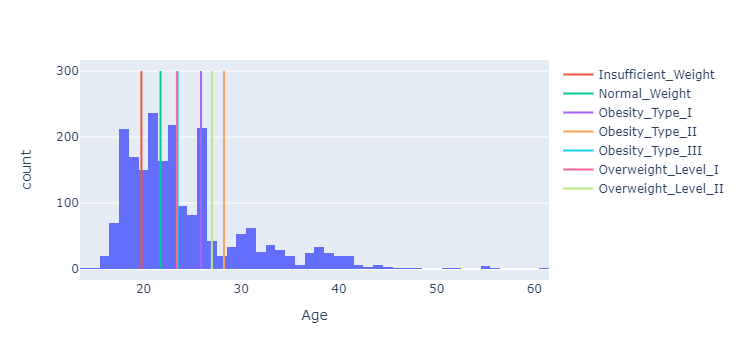

In [133]:
fig = px.histogram(Obesity_data, x="Age")

lines_on_graph(0,300)
lines_on_graph(1,300)
lines_on_graph(2,300)
lines_on_graph(3,300)
lines_on_graph(4,300)
lines_on_graph(5,300)
lines_on_graph(6,300)

fig.show()

We see that our data is right tailed with a few data records showing people in their 40's, 50's and even 60's. We also do see that Obesity and overweight might be correlated to age since our Insufficient_Weight and Normal_Weight groups are both in the younger side of our distribution when compared to the other groups.

Due to our data being skewed we don't have huge insights into how obese people do later in life through the visual above. However a correlation test below will help with this.

#### Family History

"wealth begets wealth" is a common saying. Meaning wealth brings forth more wealth as in wealthy parents might raise a child who in turn will be wealthy. Family History might tell us a lot about someones likelihood of being obese. Here we will explore if "Obesity begets obesity".

In [135]:
# Understanding how our population is split by gender
family_hisotry_split = pd.read_sql("""
select
NObeyesdad,
family_history_with_overweight,
count(*) as counts
from Obesity_data
group by 1,2
""",cnx)
family_hisotry_split

,NObeyesdad,family_history_with_overweight,counts
0,Insufficient_Weight,no,146
1,Insufficient_Weight,yes,126
2,Normal_Weight,no,132
3,Normal_Weight,yes,155
4,Obesity_Type_I,no,7
5,Obesity_Type_I,yes,344
6,Obesity_Type_II,no,1
7,Obesity_Type_II,yes,296
8,Obesity_Type_III,yes,324
9,Overweight_Level_I,no,81


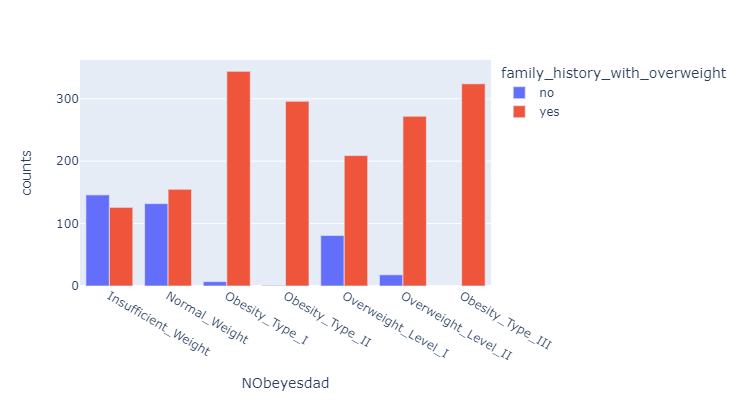

In [136]:
fig = px.bar(family_hisotry_split, x="NObeyesdad", y="counts",
             color='family_history_with_overweight',barmode='group',
             height=400)
fig.show()

We see that people with a history of Obesity of any kind seem to be more likely to be obese themselves. This seemed specially true for people that are obesity more than overweight.

#### Transportation Method

In [143]:
# Understanding how our population is split by gender
MTRANS_split = pd.read_sql("""
SELECT
MTRANS,
NObeyesdad,
count(*) as counts
FROM Obesity_data
GROUP BY 1,2
""",cnx)
MTRANS_split

,MTRANS,NObeyesdad,counts
0,Automobile,Insufficient_Weight,46
1,Automobile,Normal_Weight,45
2,Automobile,Obesity_Type_I,110
3,Automobile,Obesity_Type_II,95
4,Automobile,Obesity_Type_III,1
5,Automobile,Overweight_Level_I,66
6,Automobile,Overweight_Level_II,94
7,Bike,Normal_Weight,4
8,Bike,Obesity_Type_II,1
9,Bike,Overweight_Level_I,2


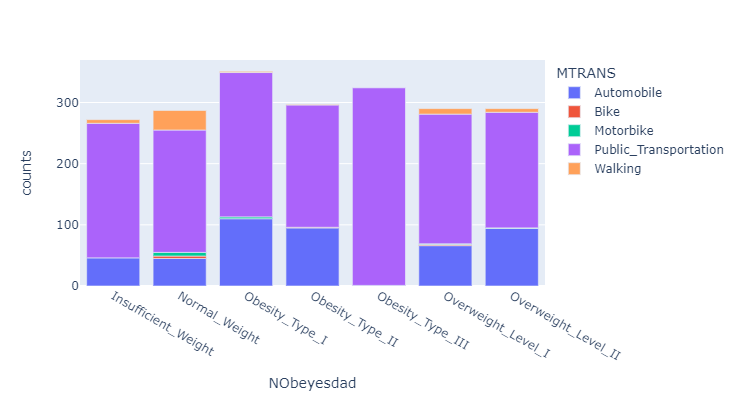

In [145]:
fig = px.bar(MTRANS_split, x="NObeyesdad", y="counts",
             color='MTRANS',
             height=400)
fig.show()

In [154]:
pd.crosstab(index=Obesity_data["NObeyesdad"],columns=Obesity_data["MTRANS"])

MTRANS,Automobile,Bike,Motorbike,Public_Transportation,Walking
NObeyesdad,,,,,
Insufficient_Weight,46,0,0,220,6
Normal_Weight,45,4,6,200,32
Obesity_Type_I,110,0,3,236,2
Obesity_Type_II,95,1,0,200,1
Obesity_Type_III,1,0,0,323,0
Overweight_Level_I,66,2,1,212,9
Overweight_Level_II,94,0,1,189,6


From both the bar chart above and the cross table we see that there seems to be some correlation between the way people move about and they weight. e.g. a lot of people who walk are in the normal weight category. A simple linear model could tell us the relationship better but all we know for now is that further analysis is needed.

In [139]:
codes, uniques  = Obesity_data.NObeyesdad.factorize()
Obesity_data['WeightCatNumeric'] = codes
Obesity_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,WeightCatNumeric
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,0
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,1
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,2


In [141]:
Obesity_data.corr()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,WeightCatNumeric
Age,1.000000,-0.025958,0.202560,0.016291,-0.043944,-0.045304,-0.144938,-0.296931,0.084565
Height,-0.025958,1.000000,0.463136,-0.038121,0.243672,0.213376,0.294709,0.051912,0.137662
Weight,0.202560,0.463136,1.000000,0.216125,0.107469,0.200575,-0.051436,-0.071561,0.634348
FCVC,0.016291,-0.038121,0.216125,1.000000,0.042216,0.068461,0.019939,-0.101135,0.343951
NCP,-0.043944,0.243672,0.107469,0.042216,1.000000,0.057088,0.129504,0.036326,0.157947
CH2O,-0.045304,0.213376,0.200575,0.068461,0.057088,1.000000,0.167236,0.011965,0.070423
FAF,-0.144938,0.294709,-0.051436,0.019939,0.129504,0.167236,1.000000,0.058562,-0.142211
TUE,-0.296931,0.051912,-0.071561,-0.101135,0.036326,0.011965,0.058562,1.000000,-0.034355
WeightCatNumeric,0.084565,0.137662,0.634348,0.343951,0.157947,0.070423,-0.142211,-0.034355,1.000000


### Modeling

Next, you should fit three different classes of models (they can be the ones we did in class or you can branch out). You can have a numeric response or a binary response. 

With each model type you use, you should describe the general idea of the model/how it works. These discussion don’t need to be super long, but they should be clear and hit on the most important points about how the model works.

You should use CV to choose among the candidate models for each model type.

  • You should set up a pipeline in pyspark for each of your models  
  
  • At least one of the pipelines should include at least two transformations prior to the model fit (estimator)  
  
  • You can use the same set of transformations for multiple models (if appropriate)